In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import cifar10
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [2]:
original_dim = 32*32*3
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0

In [3]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [4]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [5]:
def variational_autoencoder(original_dim, intermediate_dim, latent_dim):
    
    #Decoder Model
    decoder = Sequential()
    decoder.add(Dense(intermediate_dim, input_dim=latent_dim, activation='relu'))
    decoder.add(Dense(original_dim, activation='sigmoid'))
    decoder.name = "Decoder_Model"
    
    #Encoder Model
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)
    z_mu = Dense(latent_dim, name="Means")(h)
    encoder = Model(x, z_mu)
    
    #Variational Autoencoder
    z_log_var = Dense(latent_dim, name="Std_Deviations")(h)
    z_mu, z_log_var = KLDivergenceLayer(name="KLD")([z_mu, z_log_var])
    z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)
    eps = Input(tensor=K.random_normal(stddev=epsilon_std, shape=(K.shape(x)[0], latent_dim)), name="Noise")
    z_eps = Multiply()([z_sigma, eps])
    z = Add(name="Resampled_Encoding")([z_mu, z_eps])
    x_pred = decoder(z)
    
    variational_encoder = Model(inputs=[x, eps], outputs=x_pred)
    
    
    return variational_encoder, encoder, decoder


In [6]:
vae, encoder, decoder =  variational_autoencoder(original_dim, intermediate_dim, latent_dim)
vae.compile(optimizer='rmsprop', loss=nll)

In [7]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 256)          786688      input_1[0][0]                    
__________________________________________________________________________________________________
Means (Dense)                   (None, 2)            514         dense_3[0][0]                    
__________________________________________________________________________________________________
Std_Deviations (Dense)          (None, 2)            514         dense_3[0][0]                    
__________________________________________________________________________________________________
KLD (KLDiv

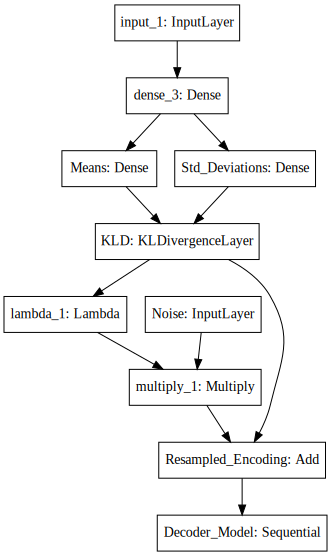

In [8]:
SVG(model_to_dot(vae).create(prog='dot', format='svg'))

In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

In [12]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 83us/step - loss: 2036.5218 - val_loss: 2003.8306
Epoch 2/50
50000/50000 [==============================] - 4s 72us/step - loss: 1975.6833 - val_loss: 1967.3625
Epoch 3/50
50000/50000 [==============================] - 4s 76us/step - loss: 1968.4005 - val_loss: 1966.4783
Epoch 4/50
50000/50000 [==============================] - 4s 81us/step - loss: 1964.3301 - val_loss: 1965.3160
Epoch 5/50
50000/50000 [==============================] - 4s 73us/step - loss: 1962.2608 - val_loss: 1961.9503
Epoch 6/50
50000/50000 [==============================] - 4s 73us/step - loss: 1961.5473 - val_loss: 1964.9404
Epoch 7/50
50000/50000 [==============================] - 4s 73us/step - loss: 1960.7583 - val_loss: 1962.5839
Epoch 8/50
50000/50000 [==============================] - 4s 76us/step - loss: 1960.2628 - val_loss: 1960.0724
Epoch 9/50
50000/50000 [==============================] - 4s 7

In [13]:
#vae.save_weights("vae-test1.h5")

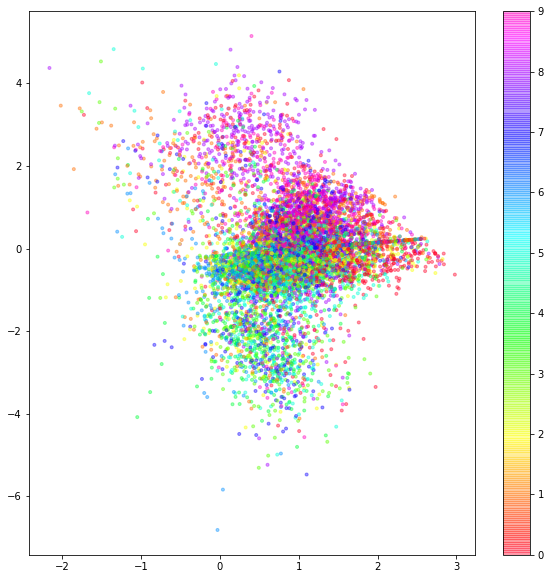

In [22]:
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10,10))
plt.scatter(z_test[:, 0], z_test[:, 1], c=np.squeeze(y_test), alpha=.4, s=3**2, cmap='gist_rainbow')
plt.colorbar()
plt.show()

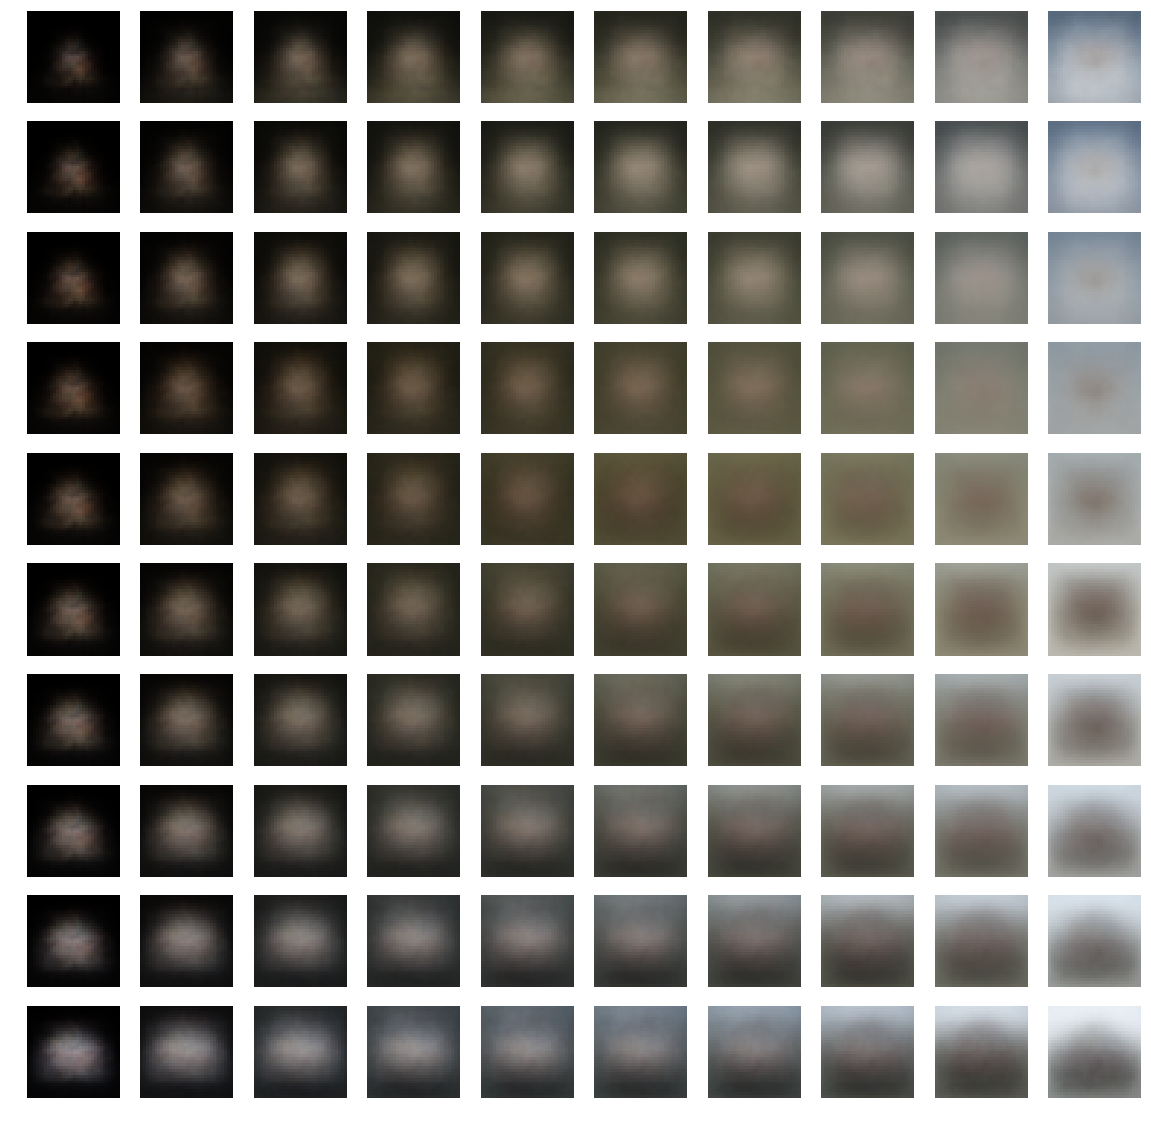

In [35]:
# display a 2D manifold of the digits
n = 10  # figure with 15x15 digits
digit_size = 32

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size, 3)

plt.rcParams["figure.figsize"] = 20,20

for i in range(n):
    for j in range(n):
        plt.subplot(n,n,n*i + j+1)
        plt.imshow(x_decoded[i][j])
        plt.axis("off")